# Forecasting Medicaid Prescription Drug Demand
*Capstone project for BrainStation Data Science diploma*

Author - Albert King<br>
Last Modified - 11 April 2022<br>
Contact - awkchemistry@gmail.com<br>

## Notebook 3

Drug shortages directly contribute to preventable deaths, drug stockpiling and rationing by hospitals and governments, and inflated drug costs. In effort to characterize the situation of current drug shortages, this project looks at reported US Medicaid drug claims by states for years 1991-2022, the most recent data currently available. In combination with the FDA's current list of shortages and anticipated shortages, time series analysis is used to forecast future demand.

This project is divided into 4 Jupyter notebooks:

- Notebook 1 imports Medicaid data into a MySQL database, explores and cleans prescription data, and prepares a list of drugs common to the Medicaid data and current FDA shortages.
- Notebook 2 explores and models the prescription data aggregated to total prescriptions per year nationwide. Fitting is accomplished through ARIMA and Facebook Prophet models.
- Notebook 3 models the data using an ARIMA multiple-point output recurrent neural network (RNN). It is separate due incompatabilities between the environments used for Notebooks 1, 2, and 4 with TensorFlow/Keras.
- Notebook 4 ingests, cleans, models, and forecasts prescription demand for individual drugs en masse.

Medicaid datasets were downloaded locally as CSV files from https://data.medicaid.gov/datasets?theme%5B0%5D=State+Drug+Utilization for all years available. The CSV files were brought into MySQL initially using command line as MySQLWorkbench was not able to handle the size of the files. This method is recreated below so as to aggregate methods into Jupyter notebooks, though the initial command line code is included in an appendix. Current drug shortages were downloaded from https://www.accessdata.fda.gov/scripts/drugshortages/default.cfm as CSV files.

This notebook imports processed Medicaid data from notebook 1 and applies an ARIMA-based RNN model to fit aggregate nationwide prescription demand. **This notebook is based off and derived from the TensorFlow** time series model https://www.tensorflow.org/tutorials/structured_data/time_series. All functions come from TensorFlow. I use a multiple output model here. Summary of the results is described in notebook 3. Methodology is summarized in the capstone summary PDF document.

## Table of Contents

- [Imports](#imports)
- [Baseline Modeling](#baseline-modeling)
- [RNN Modeling](#rnn-modeling)

## Imports

Imports specific to this notebook are listed. Note that this notebook uses the environment "deeplearning"

In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

# WARNING WARNING DONT TRY THIS AT HOME
tf.get_logger().setLevel('ERROR')

Data are next imported from the file created in notebook 1.

In [2]:
# import data exported from Book 1
parent_df = pd.read_csv('data/quarterly_rx_state.csv',index_col=0).T

# make sure data look as expected
parent_df.head(3)

,AK,AL,AZ,AR,CA,CO,CT,DE,DC,FL,...,SD,TN,TX,UT,VT,VA,WA,WV,WI,WY
03/31/1991,44447.0,541209.0,NaN,905764.0,6200227.0,379533.0,454890.0,58932.0,130940.0,2489054.0,...,59310.0,1530412.0,2118592.0,NaN,128515.0,1069960.0,893352.0,NaN,747579.0,38003.0
06/30/1991,64671.0,908574.0,NaN,904910.0,7569682.0,559830.0,950321.0,NaN,180563.0,3393291.0,...,122473.0,2044949.0,3066577.0,303904.0,193322.0,1482027.0,1264073.0,790213.0,1181954.0,75244.0
09/30/1991,78263.0,1055462.0,NaN,913206.0,9900547.0,541989.0,665685.0,106161.0,195679.0,3206257.0,...,114451.0,2119905.0,3447844.0,281662.0,207355.0,1407907.0,1294843.0,751653.0,1418717.0,65111.0


In [3]:
# find total for each date

# instantiate empty dict 
summary_dict = {}

# loop through rows
for i in parent_df.index:
    # for each date add sum of that quarter to dict
    summary_dict[i] = parent_df.loc[i].sum()

# convert to a dataframe
summary_df = pd.DataFrame.from_dict(summary_dict, orient='index', columns=['Prescriptions'])

# ensure that index is datetime type
summary_df.index = pd.to_datetime(summary_df.index)

With the data imported we can rearrange to train and test splits.

In [4]:
# train/test split
column_indices = {name: i for i, name in enumerate(summary_df.columns)}

n = len(summary_df)

# steps of train/test set
train_df = summary_df[0:int(n*0.7)]
val_df = summary_df[int(n*0.7):int(n*0.9)]
test_df = summary_df[int(n*0.9):]

num_features = summary_df.shape[1]

The next step is to isolate variables for generating windows.

In [5]:
# variables for windows

# train and stdev of train data
train_mean = train_df.mean()
train_std = train_df.std()

# normalizing dataframes for windowing
train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

The following function is used to generate windows, so that the NN fits multiple time windows.

In [6]:
# class used to generate windows to fit segments of time

class WindowGenerator():
  """
  Creates a window or set of windows for fitting. Relies on size of windows,
  shift between windows, and train, test, validation data.
  """

  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

The window generator function is now used to generate windows.

In [7]:
# generate windows

# sequential steps
w1 = WindowGenerator(input_width=24, label_width=1, shift=24,
                     label_columns=['Prescriptions'])
w1

w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['Prescriptions'])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['Prescriptions']

The windows 

In [8]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

A helper function is used to plot stacked windows.

In [9]:
def plot(self, model=None, plot_col='Prescriptions', max_subplots=3):
  """
  Inputs model and columns to plot. Output is pyplot stacked subplots for fit windows.
  """
  
  # labels are split out
  inputs, labels = self.example
  
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  
  max_n = min(max_subplots, len(inputs))
  
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Prescriptions')

# give function to window generator
WindowGenerator.plot = plot

The next function is calls attributes for generating dataset from array.

In [10]:
def make_dataset(self, data):
  """
  Calls attributes for dataset
  """
  data = np.array(data, dtype=np.float32)
  
  # instantiates attributes for dataset
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

# applies function to window generator
WindowGenerator.make_dataset = make_dataset

Define properties of functions to create datasets and strip data from a called function (to plot) to label output plots.

In [11]:
### Test lines

@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

# vars applied to window generator object
WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

# Each element is an (inputs, label) pair.
display(w2.train.element_spec)

2023-04-10 14:02:45.060924: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


(TensorSpec(shape=(None, 6, 1), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [12]:
### BASELINE FOR COMPARISON

class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

## Baseline Modeling

With the functions instantiated and data processed, we can proceed to model. First, the data are windowed, and then a baseline model is called.

In [13]:
# data are windowed

single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['Prescriptions'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['Prescriptions']

The baseline - a single step equating to a linear prediction for each step - is run for comparison to the NN model.

In [14]:
# instantiate model

baseline = Baseline(label_index=column_indices['Prescriptions'])

# evaluate model
baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

# data dicts
val_performance = {}
performance = {}

# parameter outputs
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

1/1 [==============================] - 0s 140ms/step - loss: 0.0172 - mean_absolute_error: 0.1089


The fit data are then plotted.

Input shape: (32, 24, 1)
Output shape: (32, 24, 1)


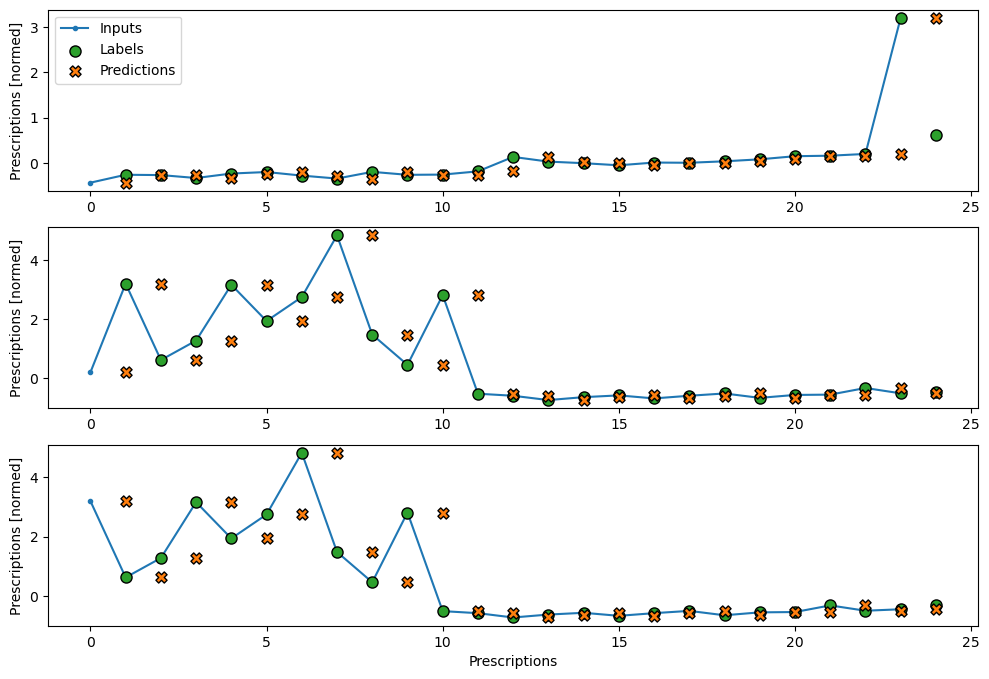

In [19]:
# data are plotted

wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['Prescriptions'])

wide_window

print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

wide_window.plot(baseline)

Having created the a baseline model we'll move on to NN modeling.

## RNN Modeling

The network needs a fist step to start, instantiated separately from the network itself.

TensorShape([32, 1])

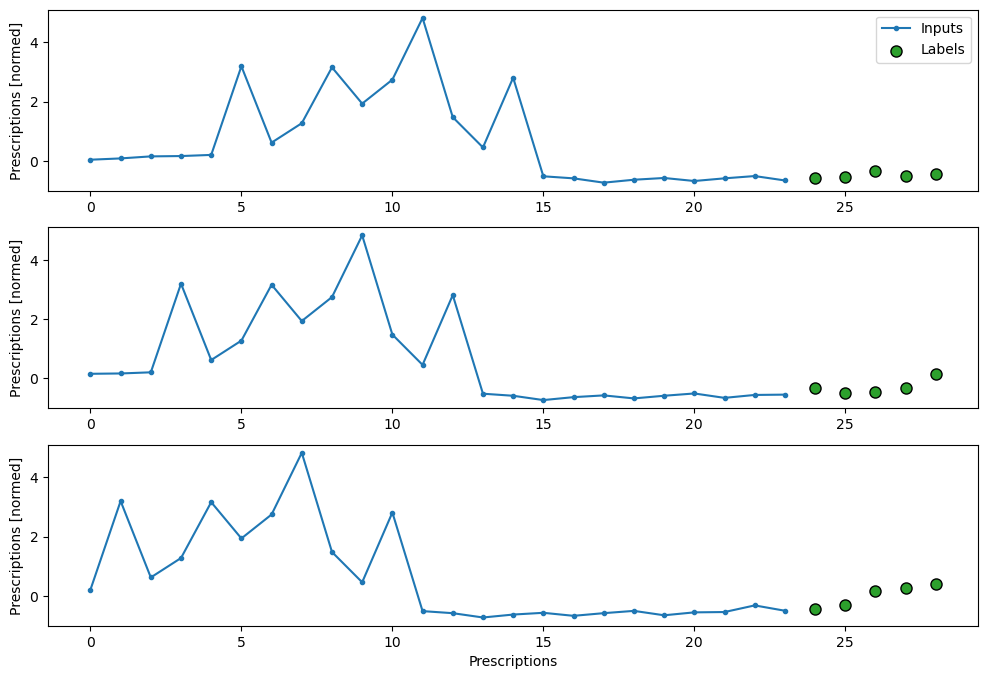

In [28]:
# Its First Step

class FeedBack(tf.keras.Model):
  # helper function for first step. Retains the current status of the network.
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    self.lstm_cell = tf.keras.layers.LSTMCell(units)
    # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dense = tf.keras.layers.Dense(num_features)

feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

def warmup(self, inputs):
  # inputs.shape => (batch, time, features)
  # x.shape => (batch, lstm_units)
  x, *state = self.lstm_rnn(inputs)

  # predictions.shape => (batch, features)
  prediction = self.dense(x)
  return prediction, state

# steps to predict forward
OUT_STEPS = 5

# relayed to window function
multi_window = WindowGenerator(input_width=24,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)


# first step is plotted
multi_window.plot()
multi_window

FeedBack.warmup = warmup

prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

A helper function is defined to use the first step and initiate the network. 

In [29]:
def call(self, inputs, training=None):
  # Use a TensorArray to capture dynamically unrolled outputs.
  predictions = []
  # Initialize the LSTM state.
  prediction, state = self.warmup(inputs)

  # Insert the first prediction.
  predictions.append(prediction)

  # Run the rest of the prediction steps.
  for n in range(1, self.out_steps):
    # Use the last prediction as input.
    x = prediction
    # Execute one lstm step.
    x, state = self.lstm_cell(x, states=state,
                              training=training)
    # Convert the lstm output to a prediction.
    prediction = self.dense(x)
    # Add the prediction to the output.
    predictions.append(prediction)

  # predictions.shape => (time, batch, features)
  predictions = tf.stack(predictions)
  # predictions.shape => (batch, time, features)
  predictions = tf.transpose(predictions, [1, 0, 2])
  return predictions

FeedBack.call = call

print('Output shape (batch, time, features): ', feedback_model(multi_window.example[0]).shape)

Output shape (batch, time, features):  (32, 5, 1)


Finally, the NN is run. In order to fit optimally, I've run 1000 epochs.

2/2 [==============================] - 1s 53ms/step - loss: 0.0936 - mean_absolute_error: 0.1446


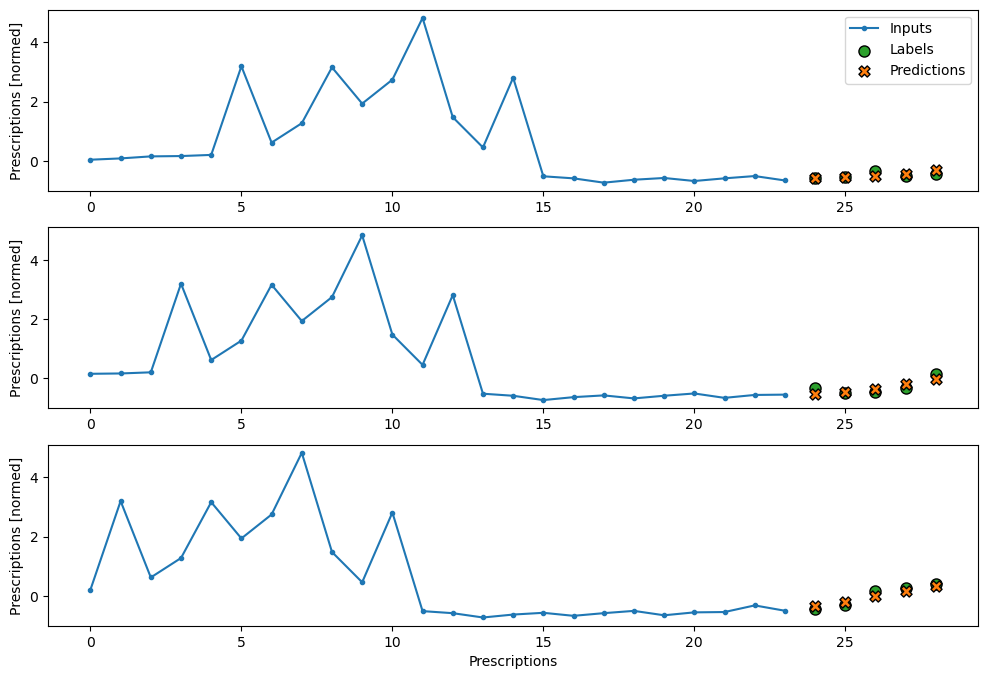

In [57]:
MAX_EPOCHS = 1

def compile_and_fit(model, window, patience=2):
  """
  Function to run the network
  """
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

history = compile_and_fit(feedback_model, multi_window)

# IPython.display.clear_output()

multi_window.plot(feedback_model)

Having fit the data using an RNN, this concludes the notebook. Please return to notebook 2 for discussion.